In [88]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt
import emcee
import corner
from PIL import Image
from scipy import stats

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [89]:
sin = lambda x: np.sin(np.deg2rad(x))
cos = lambda x: np.cos(np.deg2rad(x))
tan = lambda x: np.tan(np.deg2rad(x))

In [90]:
!ls

 cepheid_salma.csv
 cepheid_salma.ipynb
 contour_warna.gif
 gaia_RGB_parameter_awal.png
 gaia_RGB_parameter.png
'vsxgaia_calibration_vsxgaia_DCEP_MW_slope_chen_fit (1).ipynb'
 vsxgaia_calibration_vsxgaia_DCEP_MW_slope_romero-gomez_fit.ipynb
 vsx_gaia_DCEP_MW
 warna0.png
 warna100.png
 warna102.png
 warna104.png
 warna106.png
 warna108.png
 warna10.png
 warna110.png
 warna112.png
 warna114.png
 warna116.png
 warna118.png
 warna120.png
 warna122.png
 warna124.png
 warna126.png
 warna128.png
 warna12.png
 warna130.png
 warna132.png
 warna134.png
 warna136.png
 warna138.png
 warna140.png
 warna142.png
 warna144.png
 warna146.png
 warna148.png
 warna14.png
 warna150.png
 warna152.png
 warna154.png
 warna156.png
 warna158.png
 warna160.png
 warna162.png
 warna164.png
 warna166.png
 warna168.png
 warna16.png
 warna170.png
 warna172.png
 warna174.png
 warna176.png
 warna178.png
 warna180.png
 warna182.png
 warna184.png
 warna186.png
 warna188.png
 warna18.png
 warna190.png
 warna192.png
 warna

In [91]:
df = pd.read_csv('cepheid_salma.csv')

In [92]:
for col in df.columns: 
    print(col) 

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
astrometric_weight_al
astrometric_pseudo_colour
astrometric_pseudo_colour_error
mean_varpi_factor_al
astrometric_matched_observations
visibility_periods_used
astrometric_sigma5d_max
frame_rotator_object_type
matched_observations
duplicated_source
phot_g_n_obs
phot_g_mean_flux
phot_g_mean_flux_error
phot_g_mean_flux_over_error
phot_g_mean_mag
phot_bp_n_obs
phot_bp_mean_flux
phot_bp_mean_flux_error
phot_bp_mean_flux_over_error
phot_bp_mean_ma

In [93]:
d = 1 / df['parallax']
l = df['l']
b = df['b']
x0 = 8.34
z0 = 0.027

x = x0 - d * cos(l) * cos(b)
y = d * sin(l) * cos(b)
z = d * sin(b) + z0
r = np.sqrt(x**2 + y**2)
fi = np.where(x < 0, np.arctan(y/x) * 180 / np.pi + 180, np.arctan(y/x) * 180 / np.pi)
fi = np.where(fi < 0, fi + 360, fi*1)

batas = 40

df['x'], df['y'], df['z'], df['r'], df['fi'] = x, y, z, r, fi
df = df[(df['x'] < batas) & (df['x'] > -batas) & (df['y'] < batas) & (df['y'] > -batas) & (df['z'] < batas) & (df['z'] > -batas)]

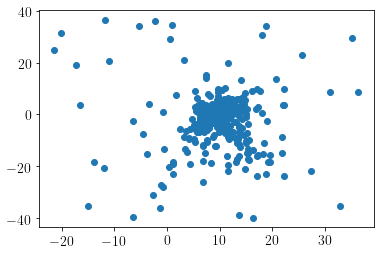

In [94]:
plt.scatter(df['x'], df['y'])

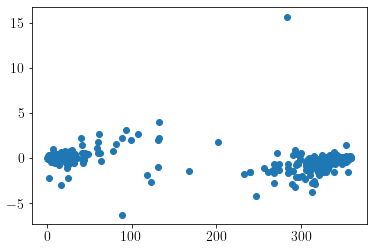

In [95]:
plt.scatter(df['fi'], df['z'])

In [96]:
df['fi'].max(), df['fi'].min()

(359.48310027877585, 0.042223541449114256)

[ 6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5
 13.  13.5 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25. ] [  0  30  60  90 120 150 180 210 240 270 300 330 360]


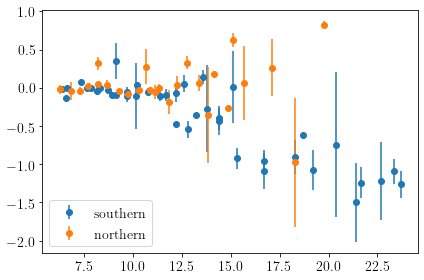

In [97]:
er = df['r'].to_numpy()
ef = df['fi'].to_numpy()
ez = df['z'].to_numpy()

gabung = er, ef, ez

r_delta = .5
r_bawah = 6.
r_atas = 25.
r_atas = r_delta + r_atas

eff = 0
f_delta = 30
f_bawah = 0
f_atas = 360
f_atas = f_delta + f_atas

binr = np.arange(r_bawah, r_atas, r_delta)
binf = np.arange(f_bawah, f_atas, f_delta)

print (binr, binf)

median = stats.binned_statistic_2d(er, ef, values=gabung, statistic='median', bins=(binr, binf))
mean = stats.binned_statistic_2d(er, ef, values=gabung, statistic='mean', bins=(binr, binf))
count = stats.binned_statistic_2d(er, ef, values=gabung, statistic='count', bins=(binr, binf))
std = stats.binned_statistic_2d(er, ef, values=gabung, statistic='std', bins=(binr, binf))

jumlah = np.ravel(count.statistic[0])
std_z = np.ravel(std.statistic[2])

min_r = np.ravel(mean.statistic[0])
min_f = np.ravel(mean.statistic[1])
min_z = np.ravel(mean.statistic[2])

med_r = np.ravel(median.statistic[0])
med_f = np.ravel(median.statistic[1])
med_z = np.ravel(median.statistic[2])

minimal = 1

jumlah_s = jumlah[jumlah > minimal]
std_z = std_z[jumlah > minimal]
std_z_ed = std_z / np.sqrt(jumlah_s)

min_r = min_r[jumlah > minimal]
min_f = min_f[jumlah > minimal]
min_z = min_z[jumlah > minimal]

med_r = med_r[jumlah > minimal]
med_f = med_f[jumlah > minimal]
med_z = med_z[jumlah > minimal]

df1 = pd.DataFrame([med_r, med_f, med_z, std_z, std_z_ed])
#df1 = pd.DataFrame([min_r, min_f, min_z, std_z, std_z_ed])
df1 = df1.T
df1.columns = ['r', 'fi', 'z', 'std_z', 'std_z_ed', ]
#df1.to_csv('mean_RGB_618_min45_45_2f.csv', index = False)

df2 = df1[df1['fi'] > 180]
df3 = df1[df1['fi'] < 180]

#plt.scatter(df2['r'], df2['z'], label = 'southern', c = 'k', s = 8)
#plt.scatter(df3['r'], df3['z'], label = 'northern', c = 'r', s = 8)

plt.errorbar(df2['r'], df2['z'], yerr=df2['std_z_ed'], fmt = 'o', label = 'southern')
plt.errorbar(df3['r'], df3['z'], yerr=df3['std_z_ed'], fmt = 'o', label = 'northern')

plt.legend()
plt.tight_layout()

0
1


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 43.562:  13%|█▎        | 25499/200000 [00:14<01:40, 1729.74it/s]
Convergence achieved at 25500
Interrupted at 25,499 [12%]: Average Loss = 723.81
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [R1, sd1, sd0, fi1, fi0, amp1, amp0]
Sampling 2 chains, 0 divergences: 100%|██████████| 20000/20000 [01:02<00:00, 321.37draws/s]
The acceptance probability does not match the target. It is 0.815320485220146, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 27.33:   8%|▊         | 16499/200000 [00:10<01:56, 1568.70it/s] 
Convergence achieved at 16500
Interrupted at 16,499 [8%]: Average Loss = 464.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, fi0, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 20000/20000 [

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1015b1b490>,
      dtype=object)

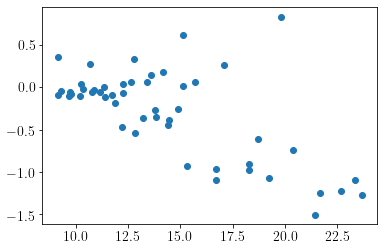

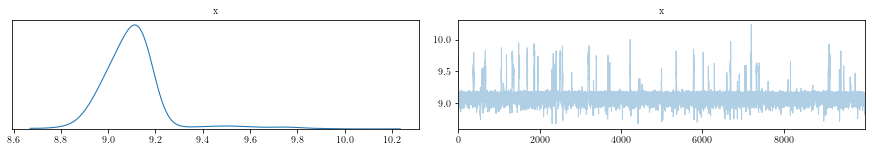

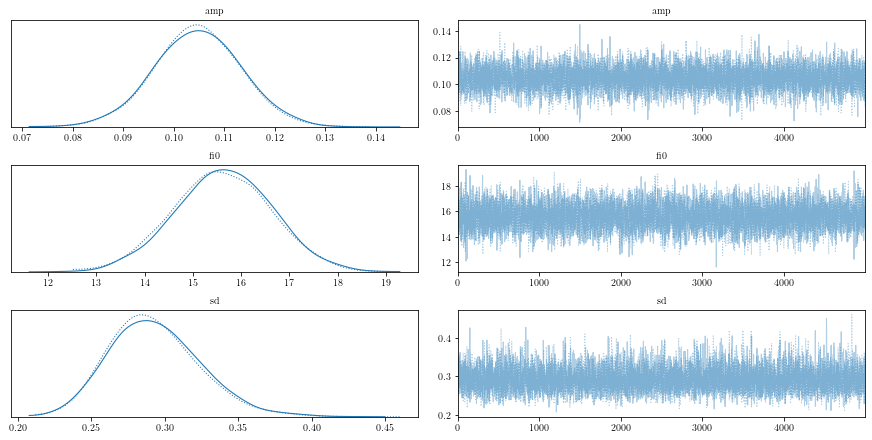

In [98]:
#df2 = pd.read_csv('../get_mean_median/data_mean_RGB_00_60_3f.csv')
#df = pd.concat([df1, df2])

N = df1['r'].count()
rmaks = df1['r'].max()
rmin = df1['r'].min()

r = df1['r'].to_numpy()
fi = df1['fi'].to_numpy()
z = df1['z'].to_numpy()

def logistic(L, x0, k=N, t=np.linspace(rmin, rmaks, N)):
    return L / (1 + tt.exp(-k * (t - x0)))

draw = 5000
rantai = 2
seed = 5

switch_bawah = 9.
switch_atas = 13.

for i in range(2):
    print (i)

with pm.Model() as m0:
    betas1 = pm.Normal('amp0', 0., 1.)
    betas2 = pm.Normal('amp1', 0., 1.)
    
    gammas1 = pm.Normal('fi0', 17., 2.)
    gammas2 = pm.Normal('fi1', 17., 2.)
    
    #b = pm.Uniform('b', 0., 0.1, shape = 2)
    
    sd1 = pm.HalfNormal('sd0', .5)
    sd2 = pm.HalfNormal('sd1', .5)
    
    switchpoints = pm.Normal('R1', 9.3, .2)
    
    amp = betas1 + logistic(betas2, switchpoints)
    fi0 = gammas1 + logistic(gammas2, switchpoints)
    dev = sd1 + logistic(sd2, switchpoints)
    #be = b[0] + logistic(b[1], switchpoints)
    
    er_r1 = np.linspace(rmin, rmaks, N)
    warp = amp * er_r1 * np.sin(np.deg2rad(fi -fi0)) #+ be

    observed = pm.Normal('Z model', mu=warp, sd=dev, observed=z)
    trace0 = pm.sample(draw, tune=draw, chains=rantai, random_seed=seed, init='advi+adapt_diag', nuts_kwargs={'target_accept':0.95})
    
    
r1 = np.median(trace0['R1'])
fi00 = np.median(trace0['fi1'])

df2 = df1[df1['r'] > r1]

plt.scatter(df2['r'], df2['z'])

rr = df2['r'].to_numpy()
zz = df2['z'].to_numpy()
ff = df2['fi'].to_numpy()

with pm.Model() as m:
    amp = pm.Normal('amp', .1, 1.)
    fi0 = pm.Normal('fi0', fi00, 1.)
    dev = pm.HalfNormal('sd', .5)
    
    er_r1 = rr - r1
    warp = amp * er_r1 * np.sin(np.deg2rad(ff -fi0))

    observed = pm.Normal('Z model', mu=warp, sd=dev, observed=zz)
    trace = pm.sample(draw, tune=draw, chains=rantai, init='advi+adapt_diag', random_seed=seed, nuts_kwargs={'target_accept':0.95})

pm.traceplot(trace0['R1'])
pm.traceplot(trace)


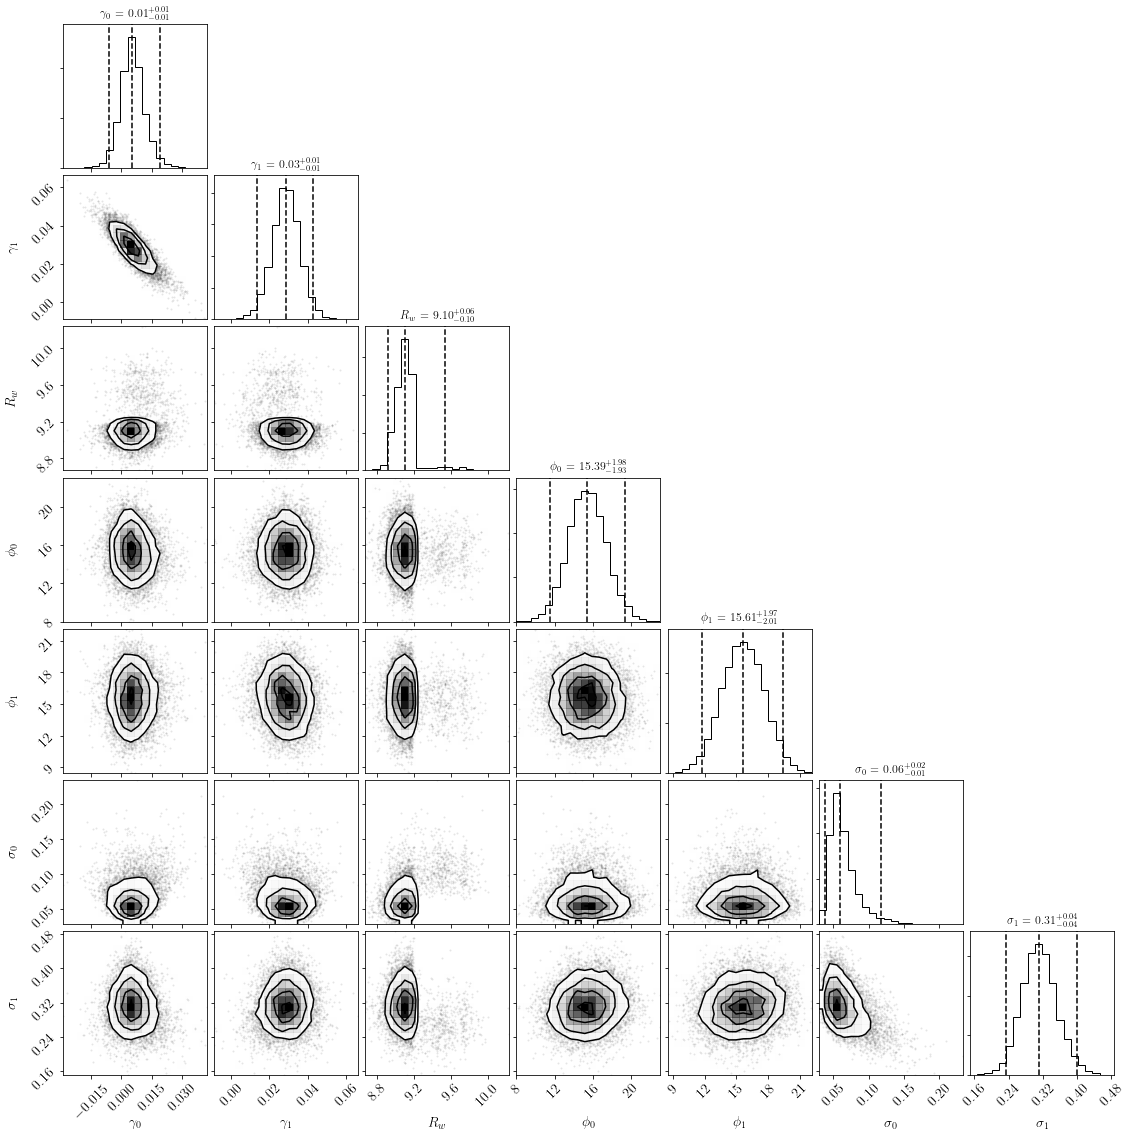

In [99]:
amp0 = trace0['amp0']#[0:5001]
amp1 = trace0['amp1']#[0:5001]

fi0 = trace0['fi0']#[0:5001]
fi1 = trace0['fi1']#[0:5001]

er1 = trace0['R1']#[0:5001]

sd0 = trace0['sd0']#[0:5001]
sd1 = trace0['sd1']#[0:5001]

postsamples = np.vstack((amp0, amp1, er1, fi0, fi1, sd0, sd1)).T

#fig = corner.corner(postsamples)

figure = corner.corner(postsamples, labels=[r"$\gamma_0$", r"$\gamma_1$", r"$R_w$", r"$\phi_0$", r"$\phi_1$", 
                                           r"$\sigma_0$", r"$\sigma_1$"],
                       quantiles=[0.025, 0.5, 0.975],
                       show_titles=True, title_kwargs={"fontsize": 12})

Text(0.5, 0, '$\\sigma_1$ (kpc)')

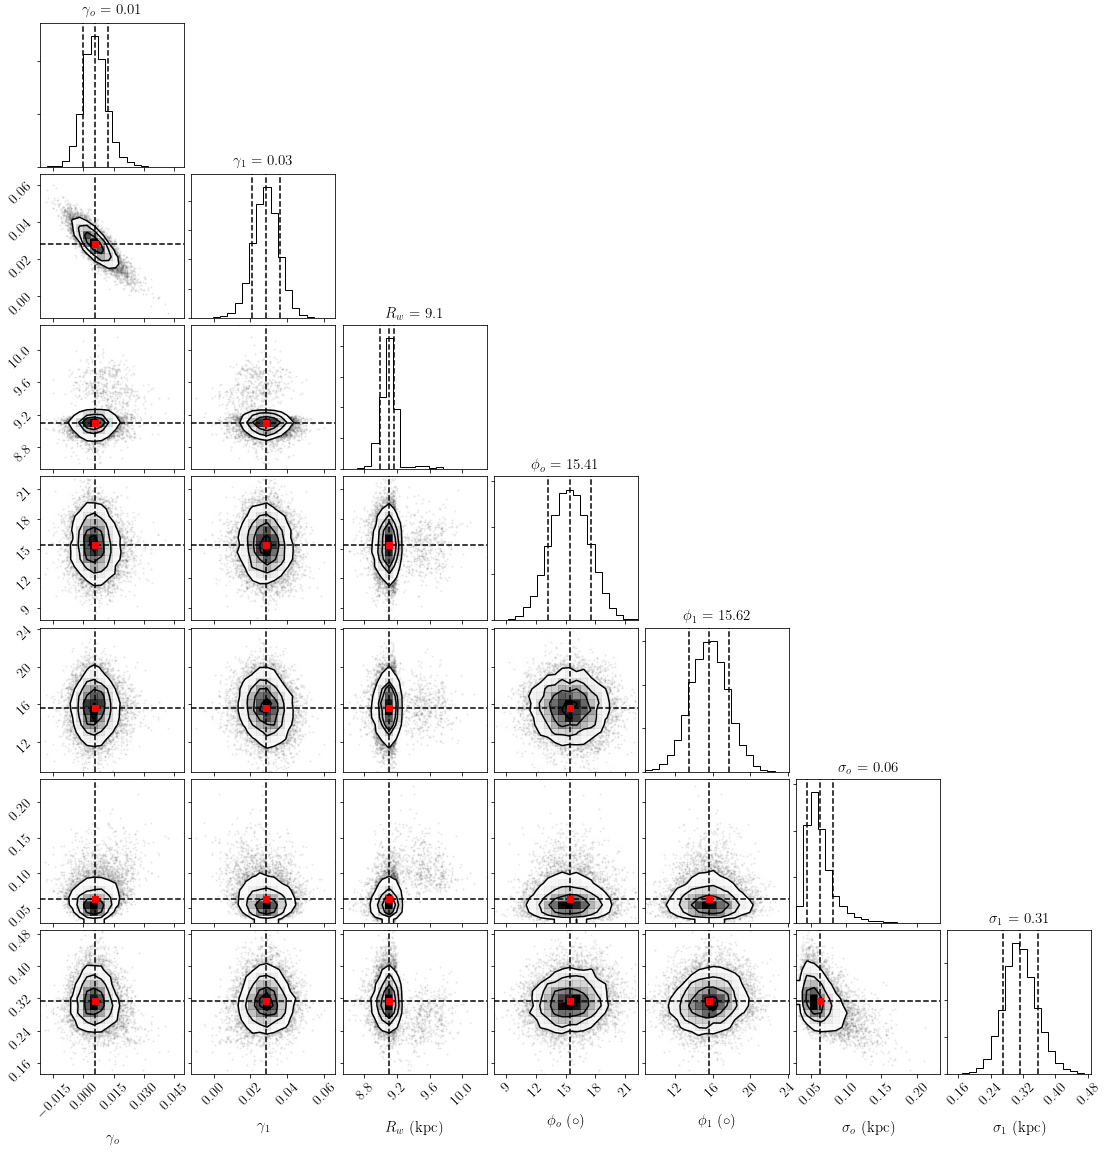

In [29]:
dro = 10_000

amp0 = trace0['amp0'][0:10000]
amp1 = trace0['amp1'][0:10000]

fi0 = trace0['fi0'][0:10000]
fi1 = trace0['fi1'][0:10000]

er1 = trace0['R1'][0:10000]

sd0 = trace0['sd0'][0:10000]
sd1 = trace0['sd1'][0:10000]

postsamples = np.vstack((amp0, amp1, er1, fi0, fi1, sd0, sd1)).T

fig = corner.corner(postsamples)

ndim = postsamples.shape[1]
axes = np.array(fig.axes).reshape((ndim, ndim))

names = ['$\gamma_o$', '$\gamma_1$', '$R_w$', '$\phi_o$', '$\phi_1$', '$\sigma_o$', '$\sigma_1$']
xlabel = ['$\gamma_o$', '$\gamma_1$', '$R_w$ (kpc)', '$\phi_o$ ($\circ$)', 
          '$\phi_1$ ($\circ$)', '$\sigma_o$ (kpc)', '$\sigma_1$ (kpc)']
q1 = np.quantile(postsamples, .14, axis = 0)
q2 = np.quantile(postsamples, .86, axis = 0)
value2 = np.mean(postsamples, axis=0)


for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value2[i], color="black", linestyle = 'dashed')
    ax.axvline(q1[i], color="black", linestyle = 'dashed')
    ax.axvline(q2[i], color="black", linestyle = 'dashed')
    strq1 = str(q1[i])
    judul = names[i] + ' $ = $ ' + str(np.round(value2[i], 2))
    ax.set_title(judul, fontsize= 15)
    
for yi in range(ndim):
    
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value2[xi], color="black", linestyle = 'dashed')
        ax.axhline(value2[yi], color="black", linestyle = 'dashed')
        ax.plot(value2[xi], value2[yi], "sr")
        ax.set_xlabel(xlabel[xi], labelpad = 15, fontsize = 15)
        
plt.xlabel(xlabel[-1], labelpad = 15, fontsize = 15)

#plt.savefig('gaia_RGB_parameter_awal.png', dpi = 300)

Text(0.5, 0, '$\\sigma_w$ (kpc)')

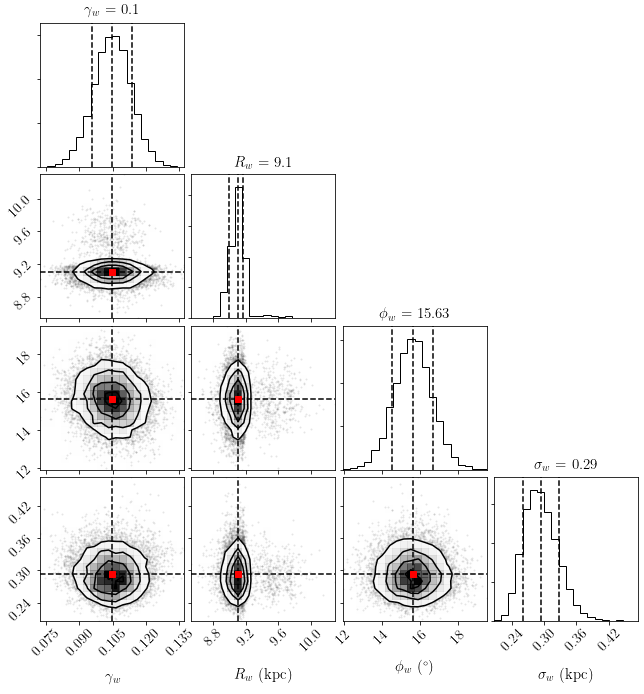

In [30]:
amp = trace['amp'][0:dro]
fi0 = trace['fi0'][0:dro]
er1 = trace0['R1'][0:dro]
sd = trace['sd'][0:dro]

postsamples = np.vstack((amp, er1, fi0, sd)).T

fig = corner.corner(postsamples)

ndim = postsamples.shape[1]
axes = np.array(fig.axes).reshape((ndim, ndim))

names = ['$\gamma_w$', '$R_w$', '$\phi_w$', '$\sigma_w$']
xlabel = ['$\gamma_w$', '$R_w$ (kpc)', '$\phi_w$ $(^\circ)$', '$\sigma_w$ (kpc)']
q1 = np.quantile(postsamples, .14, axis = 0)
q2 = np.quantile(postsamples, .86, axis = 0)
value2 = np.mean(postsamples, axis=0)


for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value2[i], color="black", linestyle = 'dashed')
    ax.axvline(q1[i], color="black", linestyle = 'dashed')
    ax.axvline(q2[i], color="black", linestyle = 'dashed')
    strq1 = str(q1[i])
    judul = names[i] + ' $ = $ ' + str(np.round(value2[i], 2))
    ax.set_title(judul, fontsize= 15)
    
for yi in range(ndim):
    
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value2[xi], color="black", linestyle = 'dashed')
        ax.axhline(value2[yi], color="black", linestyle = 'dashed')
        ax.plot(value2[xi], value2[yi], "sr")
        ax.set_xlabel(xlabel[xi], labelpad = 15, fontsize = 15)
        
plt.xlabel(xlabel[-1], labelpad = 15, fontsize = 15)

#plt.savefig('gaia_RGB_parameter.png', dpi = 300)

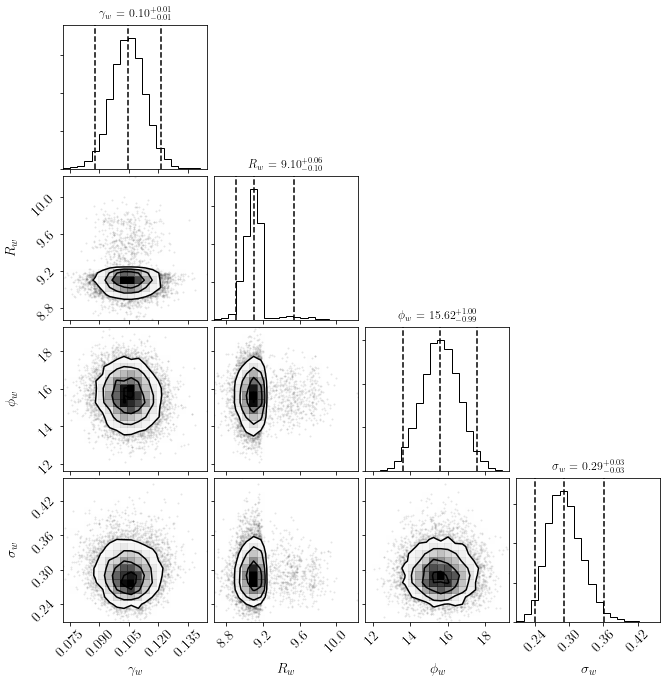

In [100]:
amp = trace['amp']
fi0 = trace['fi0']
er1 = trace0['R1']
sd = trace['sd']

postsamples = np.vstack((amp, er1, fi0, sd)).T

figure = corner.corner(postsamples, labels=[r"$\gamma_w$", r"$R_w$", r"$\phi_w$", r"$\sigma_w$"],
                       quantiles=[0.025, 0.5, 0.975],
                       show_titles=True, title_kwargs={"fontsize": 12})

In [101]:
az.ess(trace0), az.ess(trace), az.mcse(trace0), az.mcse(trace)

(<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     amp0     float64 3.28e+03
     amp1     float64 3.597e+03
     fi0      float64 5.089e+03
     fi1      float64 6.564e+03
     R1       float64 1.815e+03
     sd0      float64 1.878e+03
     sd1      float64 3.115e+03,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     amp      float64 7.749e+03
     fi0      float64 8.214e+03
     sd       float64 8.614e+03,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     amp0     float64 0.0001113
     amp1     float64 0.0001245
     fi0      float64 0.02802
     fi1      float64 0.02447
     R1       float64 0.004819
     sd0      float64 0.0005697
     sd1      float64 0.0007496,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     amp      float64 9.691e-05
     fi0      float64 0.01098
     sd       float64 0.0003384)

In [102]:
kat_r1 = az.hpd(er1, credible_interval=.95)
kat_amp = az.hpd(amp, credible_interval=.95)
kat_fi0 = az.hpd(fi0, credible_interval=.95)

CI_r1 = (er1 > kat_r1[0]) & (er1 < kat_r1[1])
CI_amp = (amp >= kat_amp[0]) & (amp < kat_amp[1])
CI_fi0 = (fi0 > kat_fi0[0]) & (fi0 < kat_fi0[1])

awi = amp[CI_amp]  #amp#[-1001:-1]
fwi = fi0[CI_fi0]  #fi0#[-1001:-1]
rwi = er1[CI_r1]   #er1#[-1001:-1]

np.median(amp) - kat_amp[0], kat_amp[1] - np.median(amp), np.median(fi0) - kat_fi0[0], kat_fi0[1] - np.median(fi0), np.median(er1) - kat_r1[0], kat_r1[1] - np.median(er1)

(0.017510268023514214,
 0.016176840987609742,
 2.0328217307853382,
 1.8779503154306987,
 0.29238638029422503,
 0.23815471032902202)

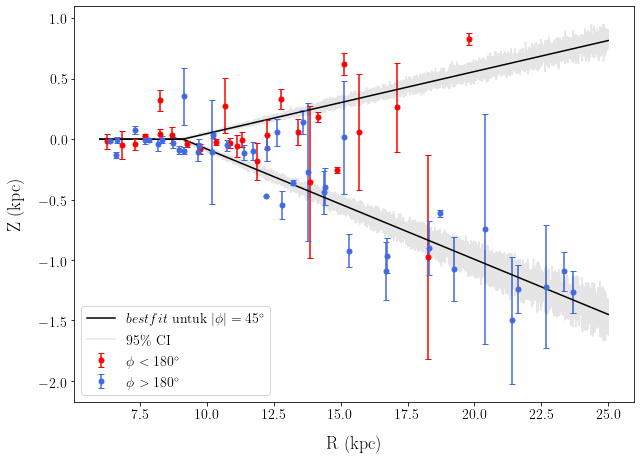

In [59]:
warna = 'k'

batas1 = 35
batas2 = batas1 - 10

dfii = df1[(df1['fi'] < 180) ]
dfiim = df1[(df1['fi'] > 180)]

minminf1 = np.mean(dfii['fi'])
minminf2 = np.mean(dfiim['fi'])

aw_best = np.mean(amp)
fw_best = np.mean(fi0)
rw_best = np.mean(er1)

kat_r1 = az.hpd(er1, credible_interval=.95)
kat_amp = az.hpd(amp, credible_interval=.95)
kat_fi0 = az.hpd(fi0, credible_interval=.95)

CI_r1 = (er1 > kat_r1[0]) & (er1 < kat_r1[1])
CI_amp = (amp >= kat_amp[0]) & (amp < kat_amp[1])
CI_fi0 = (fi0 > kat_fi0[0]) & (fi0 < kat_fi0[1])

awi = amp[CI_amp]  #amp#[-1001:-1]
fwi = fi0[CI_fi0]  #fi0#[-1001:-1]
rwi = er1[CI_r1]   #er1#[-1001:-1]

#er1[CI_r1].shape, amp[CI_amp].shape, fi0[CI_fi0].shape

ermax = dfiim['r'].max()
xx = np.linspace(6., 25., er1[CI_r1].shape[0])

fi1 = 45

warp_simple1 = np.where(xx < rw_best, 0, aw_best * (xx - rw_best) * np.sin(np.deg2rad(fi1 - fw_best)))
warp_simple2 = np.where(xx < rw_best, 0, aw_best * (xx - rw_best) * np.sin(np.deg2rad(-fi1 - fw_best)))

warpi1 = np.where(xx < rwi, 0, awi * (xx - rwi) * np.sin(np.deg2rad(fi1 - fwi)))
warpi2 = np.where(xx < rwi, 0, awi * (xx - rwi) * np.sin(np.deg2rad(-fi1 - fwi)))

plt.figure(figsize=(9, 6.5))

plt.plot(xx, warp_simple1, c = warna, label = '$best fit$ untuk $|\phi| = 45^\circ$')
plt.plot(xx, warp_simple2, c = warna, )

plt.plot(xx, warpi1, c = warna, alpha = .1, label = '$95\%$ CI')
plt.plot(xx, warpi2, c = warna , alpha = .1)

plt.errorbar(dfii['r'], dfii['z'], dfii['std_z_ed'], fmt = 'o', ms = 5, c= 'red', ecolor='red', 
             capsize=3, label = '$\phi$ $< 180^\circ$')
plt.errorbar(dfiim['r'], dfiim['z'], dfiim['std_z_ed'], fmt = 'o', ms = 5, c= 'royalblue', ecolor='royalblue', 
             capsize=3, label = '$\phi$ $> 180^\circ$')

warna = 'k'

#plt.fill_between(xx, *np.percentile(warp_simple1, q=(50.,97.5), axis=0), color="tab:orange")

#ax.fill_between(dates_with_foracast, *np.percentile(trace.new_cases, q=(2.5,97.5), axis=0), alpha=0.3, color="tab:orange", label="95% CI")

plt.xlabel('R (kpc)', fontsize = 18, labelpad = 14)
plt.ylabel('Z (kpc)', fontsize = 18, labelpad = 14)
plt.legend(loc = 'best')
plt.tight_layout()

#plt.savefig('gaia_best_fit_RGB.png', dpi = 300)

(-2.0, 2.0)

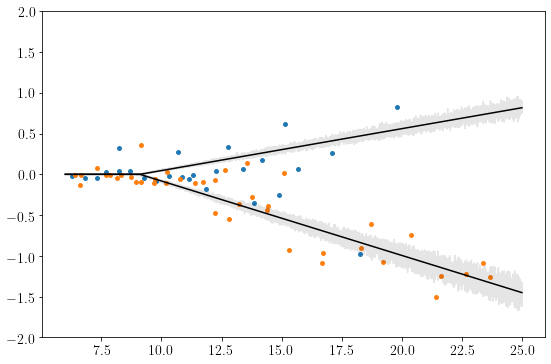

In [71]:
plt.figure(figsize=(9, 6))

plt.plot(xx, warp_simple1, c = warna, label = '$best fit$ untuk $|\phi| = 45^\circ$')
plt.plot(xx, warp_simple2, c = warna, )

plt.plot(xx, warpi1, c = warna, alpha = .1, label = '$95\%$ CI')
plt.plot(xx, warpi2, c = warna , alpha = .1)

plt.scatter(dfii['r'], dfii['z'], s = 15)
plt.scatter(dfiim['r'], dfiim['z'], s = 15)
plt.ylim(-2, 2)

Z maksimal  :  10.942461419112755
Z minimal   :  -10.942461419112755


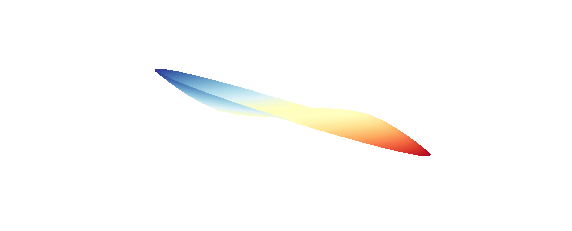

In [21]:
er = np.linspace(0, 20, 10)       
fi = np.linspace(0, 360, 76)      
r1 = 9                            
alpha = .3                    
ef = (er - r1 )

eff, fii = np.meshgrid(ef, fi)

z_w = np.where(er < r1, 0,  alpha * eff**1.5 * sin(fii)) 

#transformasi ke XYZ untuk visualisasi
x = cos(fii) * er
y = sin(fii) * er
z = z_w

print ('Z maksimal  : ', z.max())
print ('Z minimal   : ', z.min())

fig = plt.figure(figsize=(10, 4))
#ax = plt.axes(projection='3d')
ax = plt.gca(projection = '3d')
ax._axis3don = False
ax.contourf(x, y, z, 300, cmap = 'RdYlBu')
#p = ax.plot_wireframe(x, y, z, color = 'black')
ax.set_xlabel('X (kpc)', labelpad = 13)
ax.set_ylabel('Y (kpc)', labelpad = 13)
ax.set_zlabel('Z (kpc)', labelpad = 13)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis._axinfo['grid']['color'] = (1, 1, 1, 0)
ax.yaxis._axinfo['grid']['color'] = (1, 1, 1, 0)
ax.zaxis._axinfo['grid']['color'] = (1, 1, 1, 0)

ax.set_zlim(-15, 15)
ax.view_init(10, 180)

Z maksimal  :  10.942461419112755
Z minimal   :  -10.942461419112755


<ipython-input-22-0fa5106fe179>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


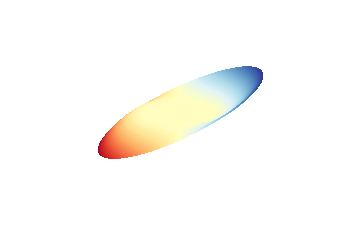

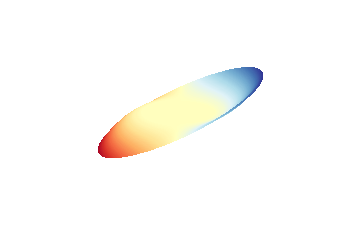

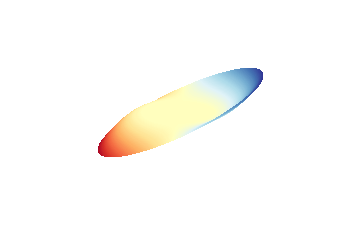

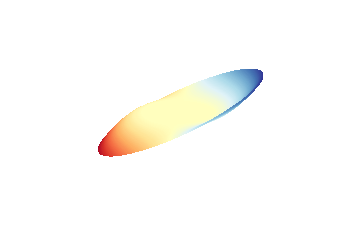

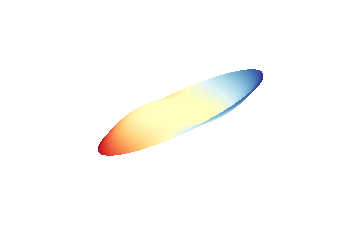

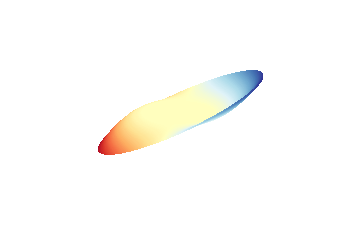

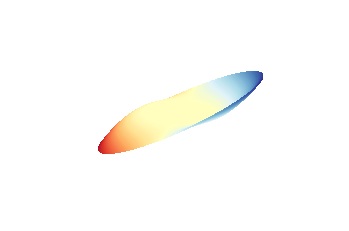

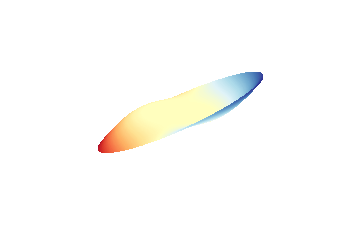

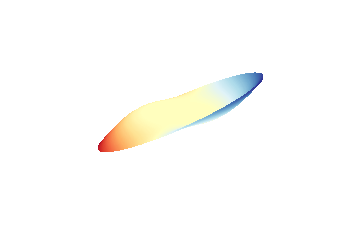

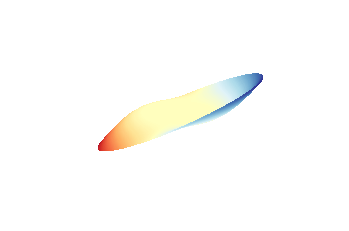

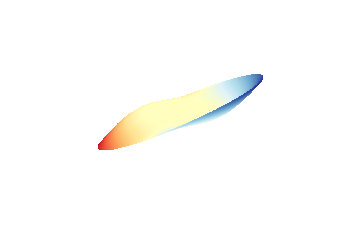

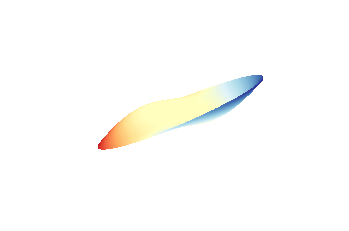

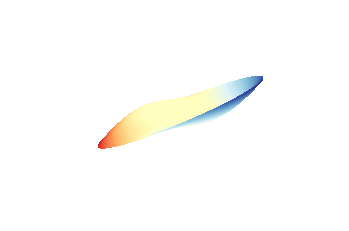

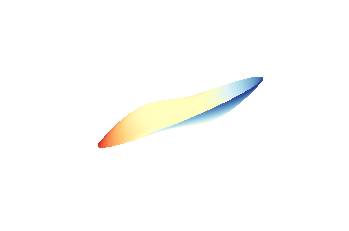

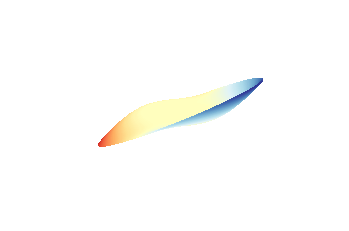

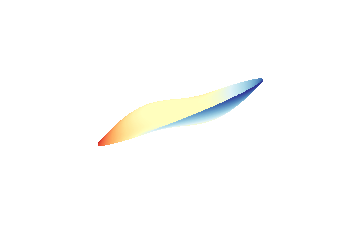

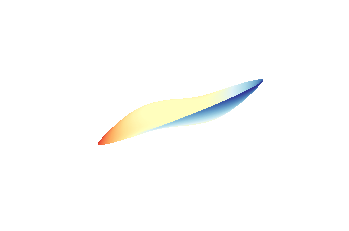

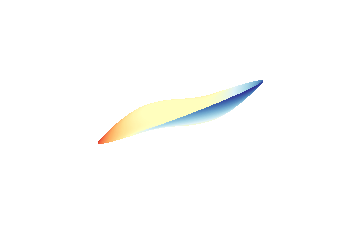

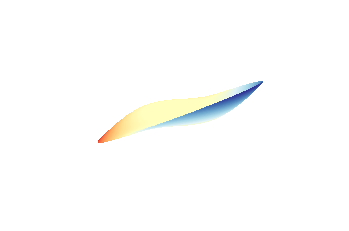

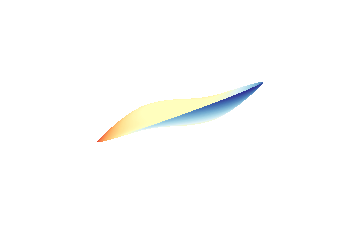

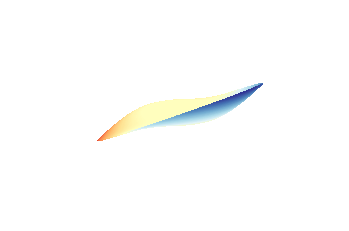

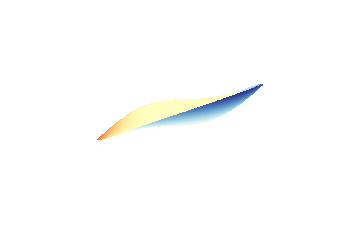

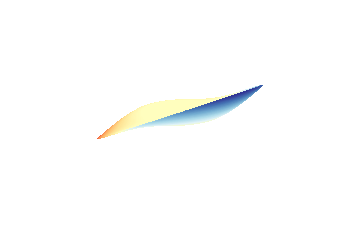

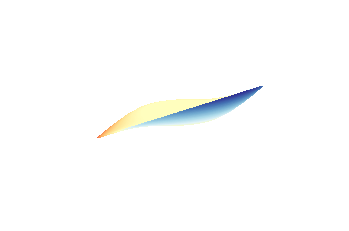

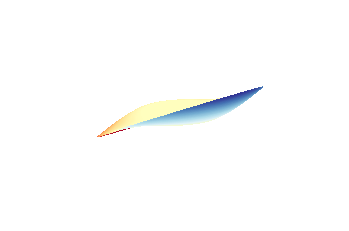

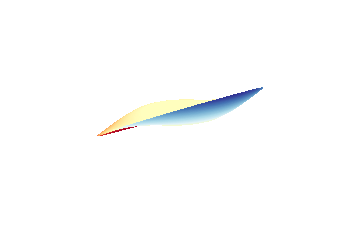

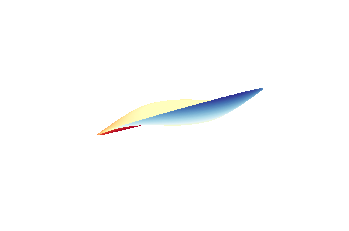

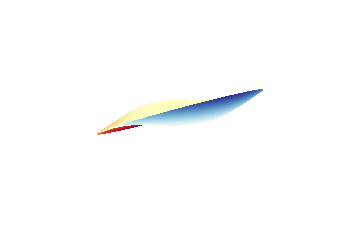

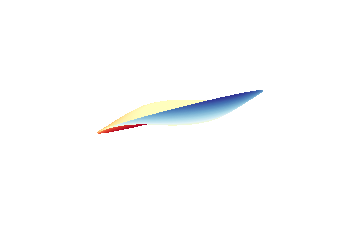

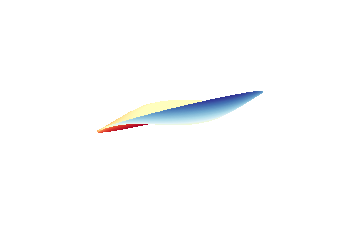

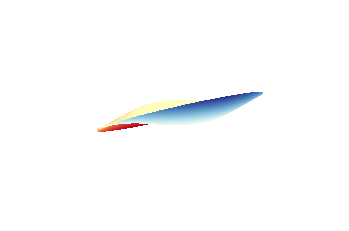

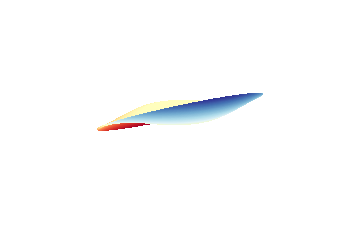

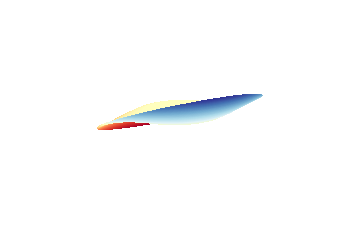

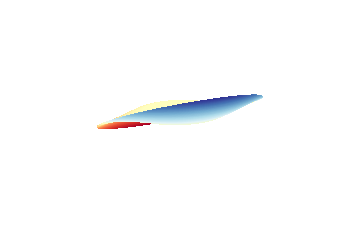

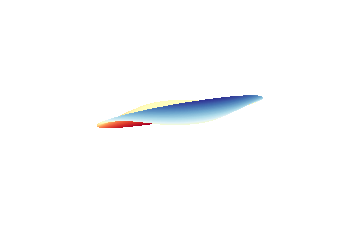

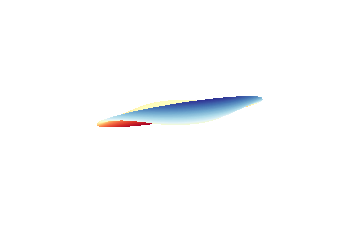

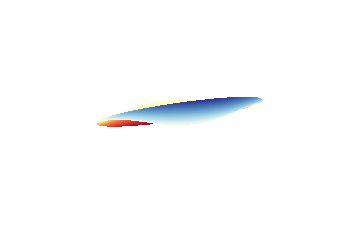

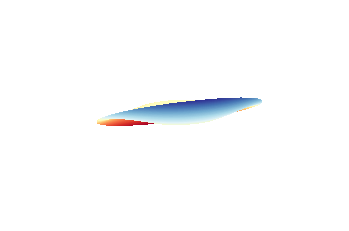

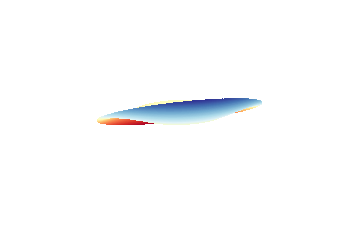

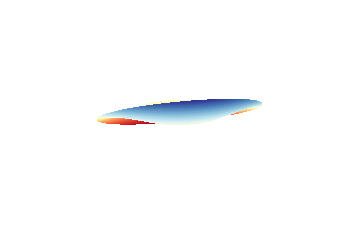

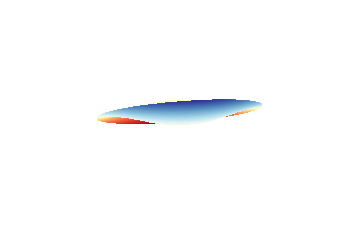

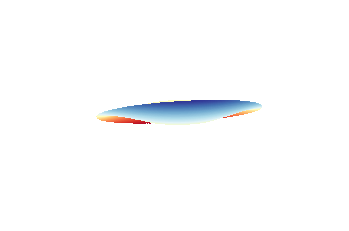

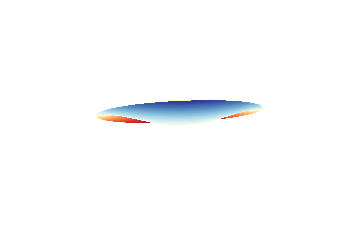

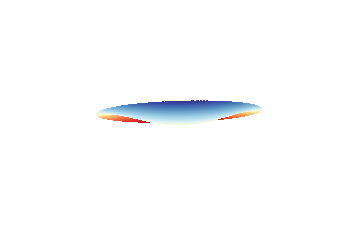

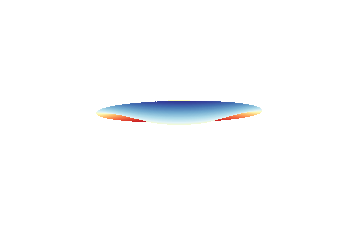

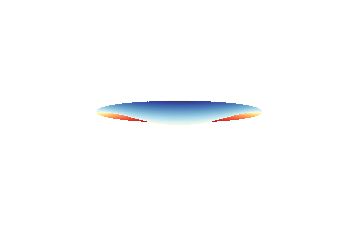

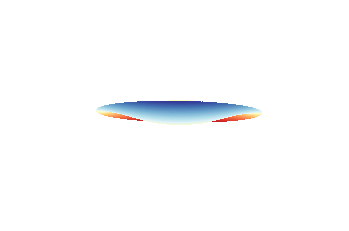

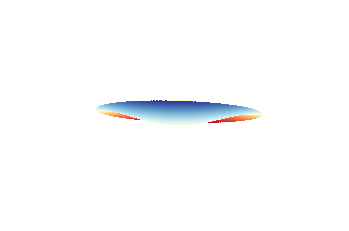

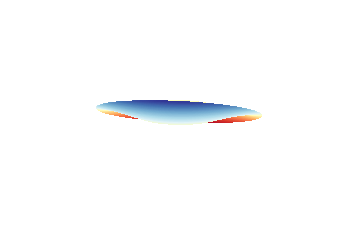

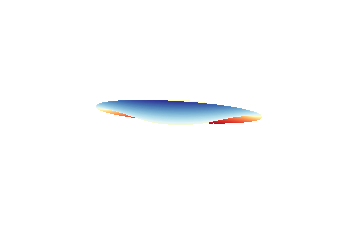

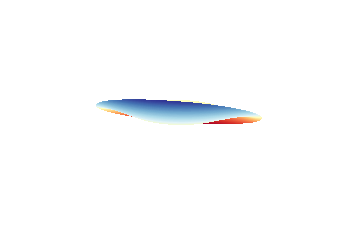

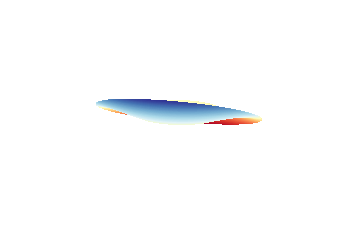

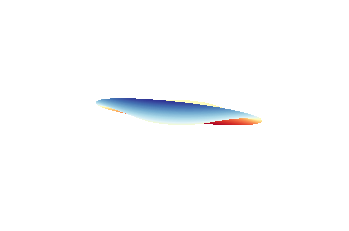

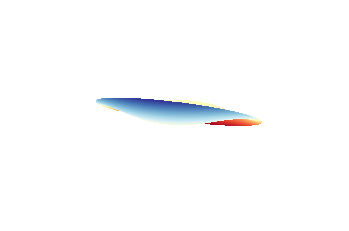

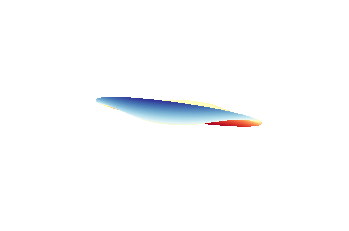

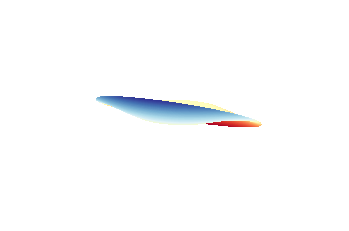

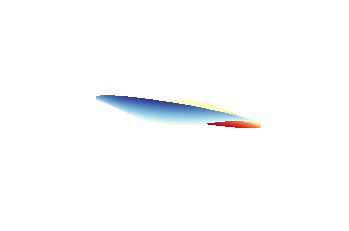

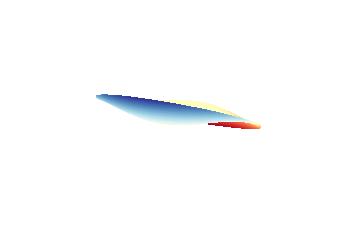

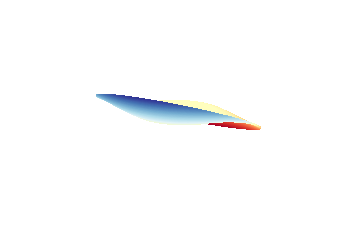

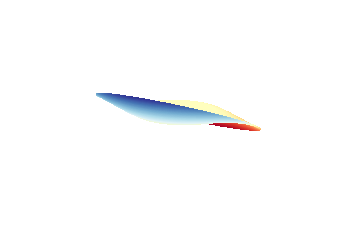

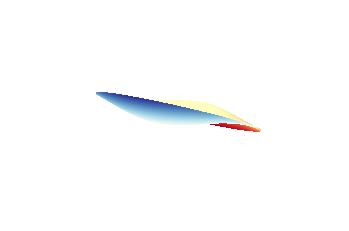

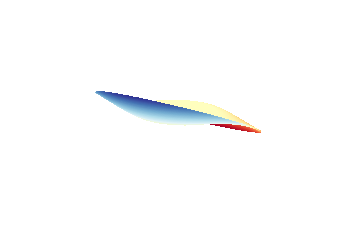

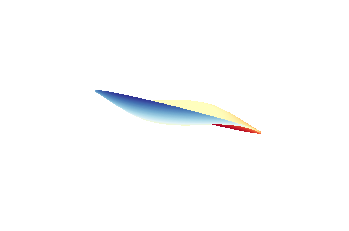

Error in callback <function flush_figures at 0x7fb1968af700> (for post_execute):


KeyboardInterrupt: 

In [22]:
er = np.linspace(0, 20, 10)       
fi = np.linspace(0, 360, 76)      
r1 = 9                            
alpha = .3                    
ef = (er - r1 )

eff, fii = np.meshgrid(ef, fi)

z_w = np.where(er < r1, 0,  alpha * eff**1.5 * sin(fii))   #tidak linear

#transformasi ke XYZ untuk visualisasi
x = cos(fii) * er
y = sin(fii) * er
z = z_w

print ('Z maksimal  : ', z.max())
print ('Z minimal   : ', z.min())

for angle in range(0, 360, 2):
    #Make the plot
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = plt.gca(projection = '3d')
    ax._axis3don = False
    
    #ax.plot_wireframe(x, y, z, color = 'gray', alpha = .7)
    ax.contourf(x, y, z, 300, cmap = 'RdYlBu')
    ax.set_xlabel('X (kpc)', labelpad = 13)
    ax.set_ylabel('Y (kpc)', labelpad = 13)
    ax.set_zlabel('Z (kpc)', labelpad = 13)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis._axinfo['grid']['color'] = (1, 1, 1, 0)
    ax.yaxis._axinfo['grid']['color'] = (1, 1, 1, 0)
    ax.zaxis._axinfo['grid']['color'] = (1, 1, 1, 0)

    ax.set_zlim(-15, 15)

    # Set the angle of the camera
    ax.view_init(30,angle)
    #Save it
    filename='warna'+str(angle)+'.png'
    plt.savefig(filename, dpi=300)
    plt.gca()

In [38]:
files = []
for i in range(0, 360, 2):
    urut = str(i)
    nama_file = 'warna'+urut+'.png'
    files.append(nama_file)

In [42]:
# Create the frames
frames = []
imgs = files
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
#save into a GIF file that loops forever
frames[0].save('contour_warna.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=40, loop=0)